In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sncosmo
from classes import Bandpasses, LightCurve, SNSurvey

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the LSST filters

In [3]:
bandpasses = Bandpasses()

Simulate a survey of SN1a

In [4]:
%%time
model = sncosmo.Model(source='salt2-extended')
params = {'z': 0, 't0': 0, 'x0': 1e-5, 'x1': 0.1, 'c': -0.1}
model.update(params)

survey = SNSurvey(model=model, area=1, cadence=1)
survey.simulate(bandpasses, norm=10, Ncpus=8)

print(survey)

SN Survey Simulation: 

    N obs = 620    
     zmin = 0      
     zmax = 1      
     area = 1      
 duration = 1000.0 
  cadence = 1      
flux errf = 0.05   

Model: 
source:
  class      : SALT2Source
  name       : 'salt2-extended'
  version    : 2.0
  phases     : [-20, .., 50] days
  wavelengths: [1700, .., 24990] Angstroms
parameters:
  z  = 0.0
  t0 = 0.0
  x0 = 1e-05
  x1 = 0.1
  c  = -0.1
CPU times: user 1.22 s, sys: 354 ms, total: 1.58 s
Wall time: 7.3 s


Print the first observation as an example:

In [5]:
print(survey.obs[0])

SkyObject Observation: 

     source = SN1a   
         t0 = 60182.1023 
     spec-z = 0.9029 
    photo-z = None   
photo-z err = None   
      N obs = 133    

   mjd     filter   flux   flux_err
---------- ------ -------- --------
60144.2873  lssty 0.001155  5.9e-05
60145.4247  lsstu 0.000989    5e-05
60146.2395  lsstg 0.008384 0.000426
60147.1044  lsstr 0.000964    5e-05
60148.1995  lssti 0.027812  0.00125
60149.4168  lsstz 0.070046 0.003454
       ...    ...      ...      ...
60271.4202  lsstu 0.001018    5e-05
60272.3892  lsstg 0.063595 0.003523
60273.2715  lsstr 0.090471 0.004419
60274.4898  lssti 0.308189 0.015471
60275.2087  lsstz 0.378841 0.018143
60276.3816  lssty 0.398588 0.019517
Length = 133 rows


Plot the flux of the SALT2 model the survey is simulated from

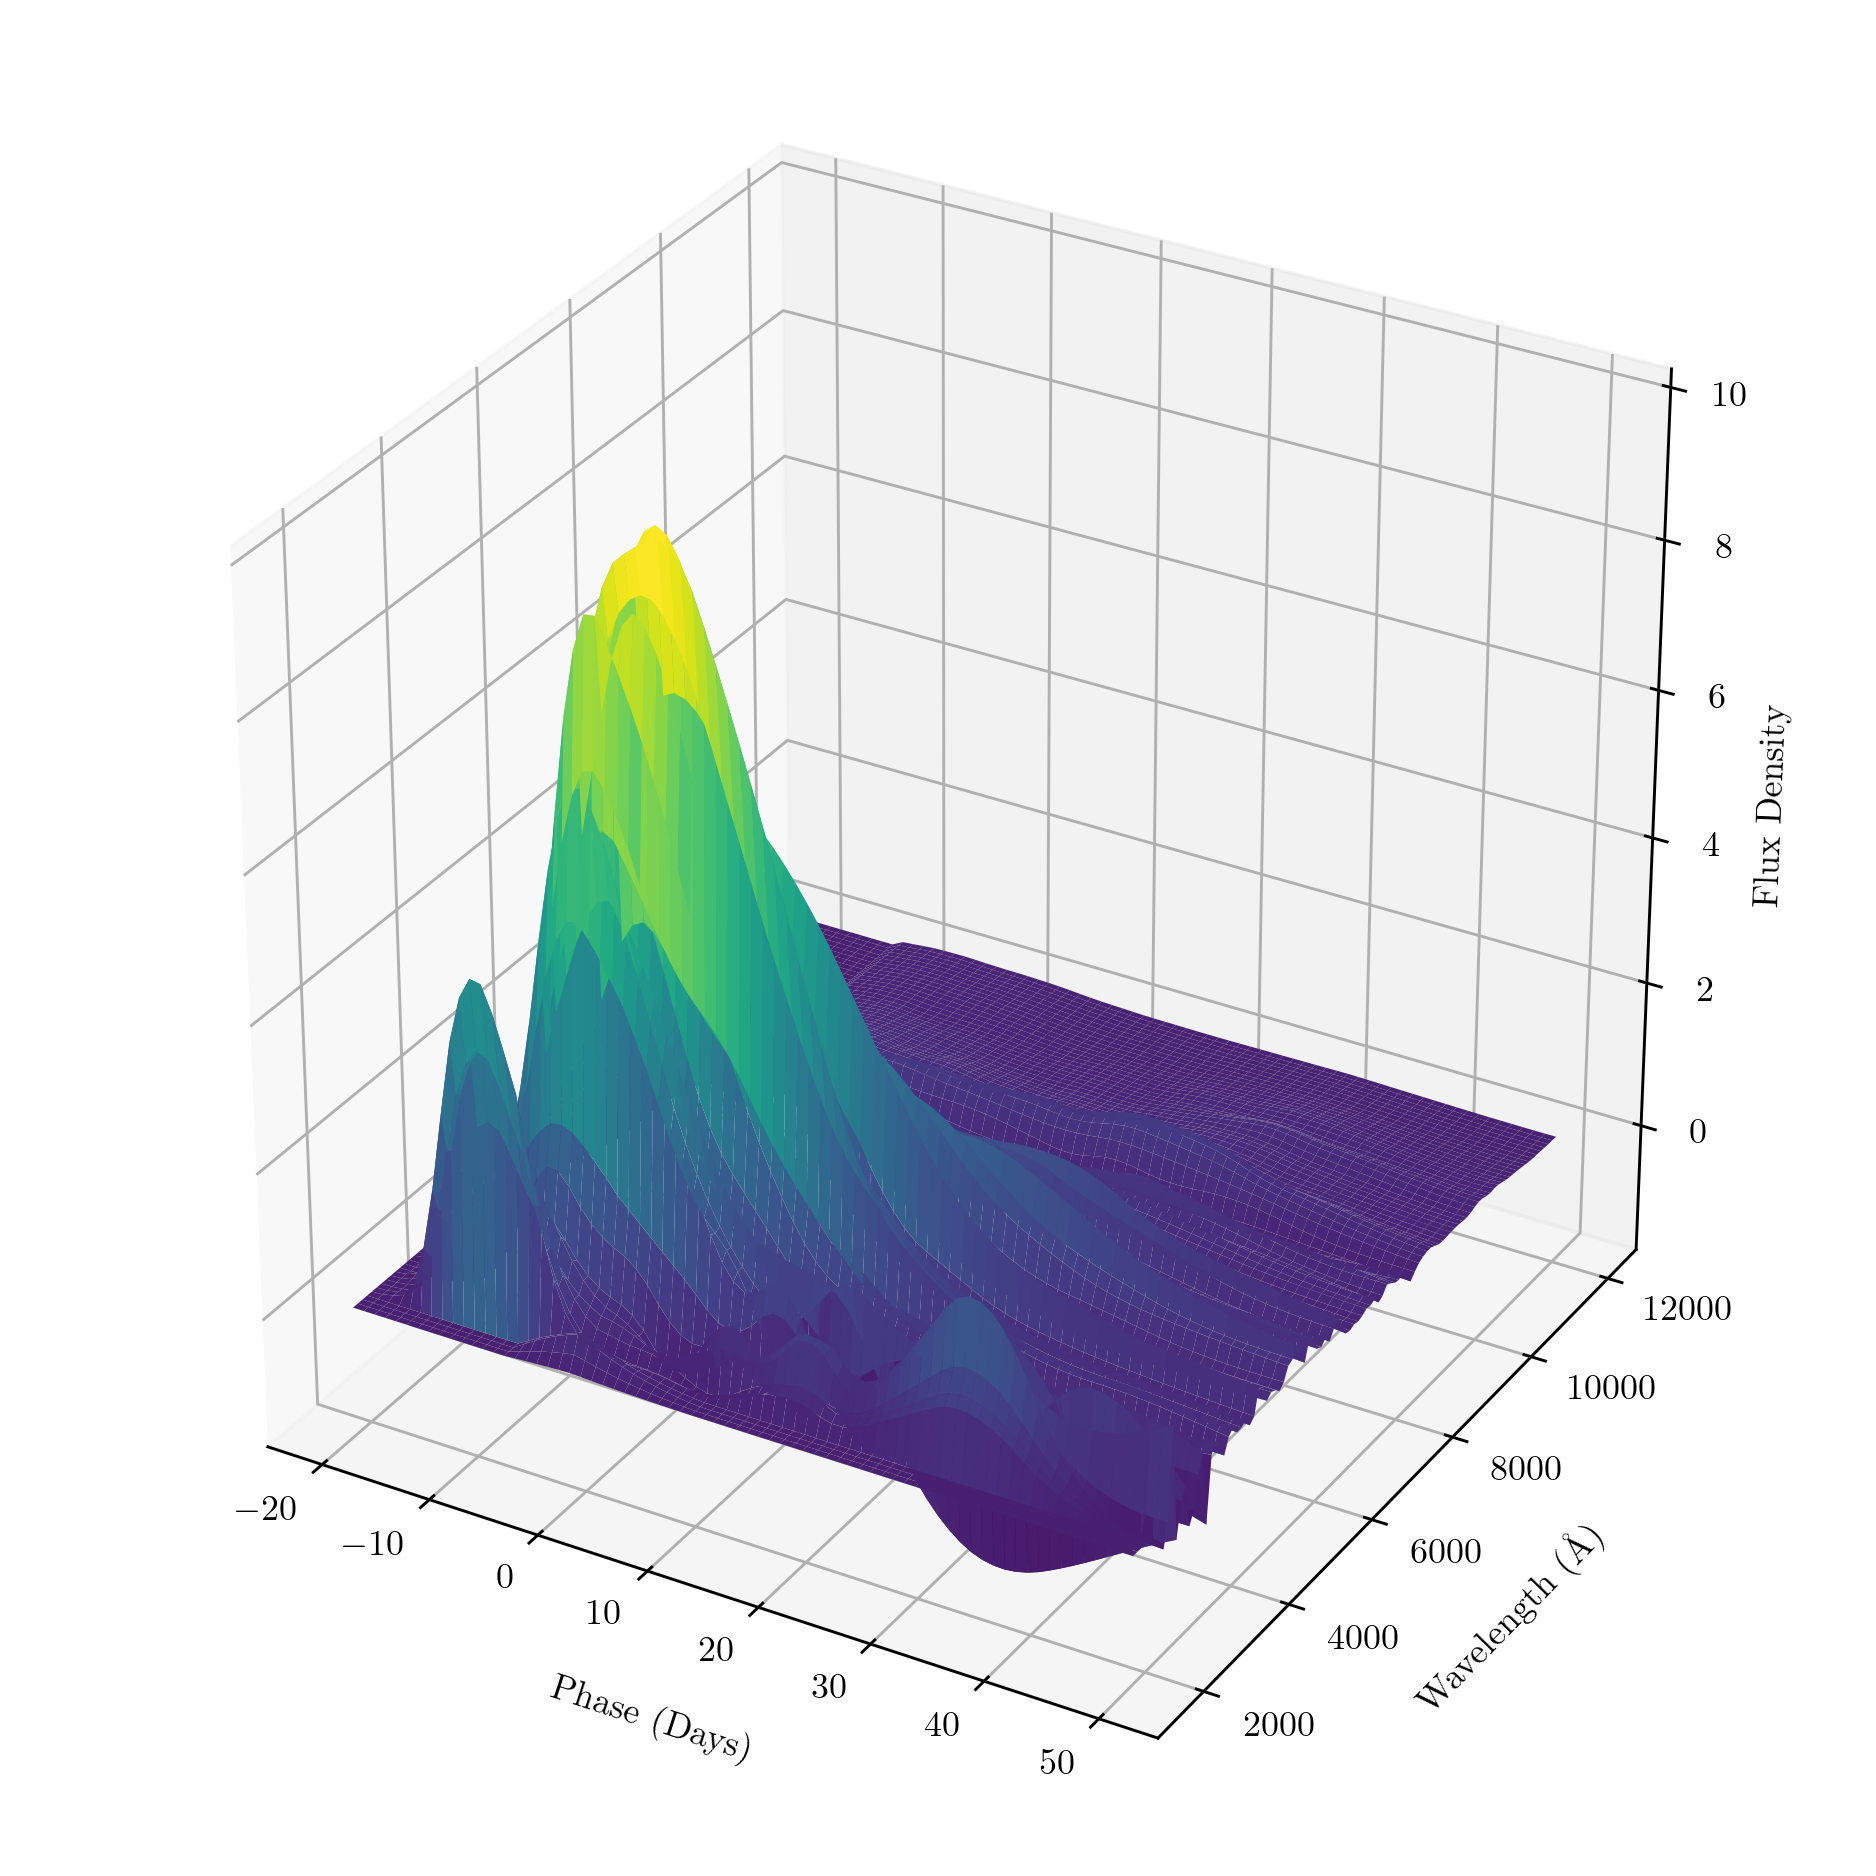

In [6]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 12100, 100)
lc = LightCurve(time, wavelen)
lc.from_model(model)
fig = lc.surface_plot()
fig = lc.contour_plot()

Now we start with a totally null light curve

In [7]:
time = np.arange(model.mintime(), model.maxtime() + 1)
wavelen = np.arange(model.minwave(), 12100, 100)
lcn = LightCurve(time, wavelen)
lcn.null()

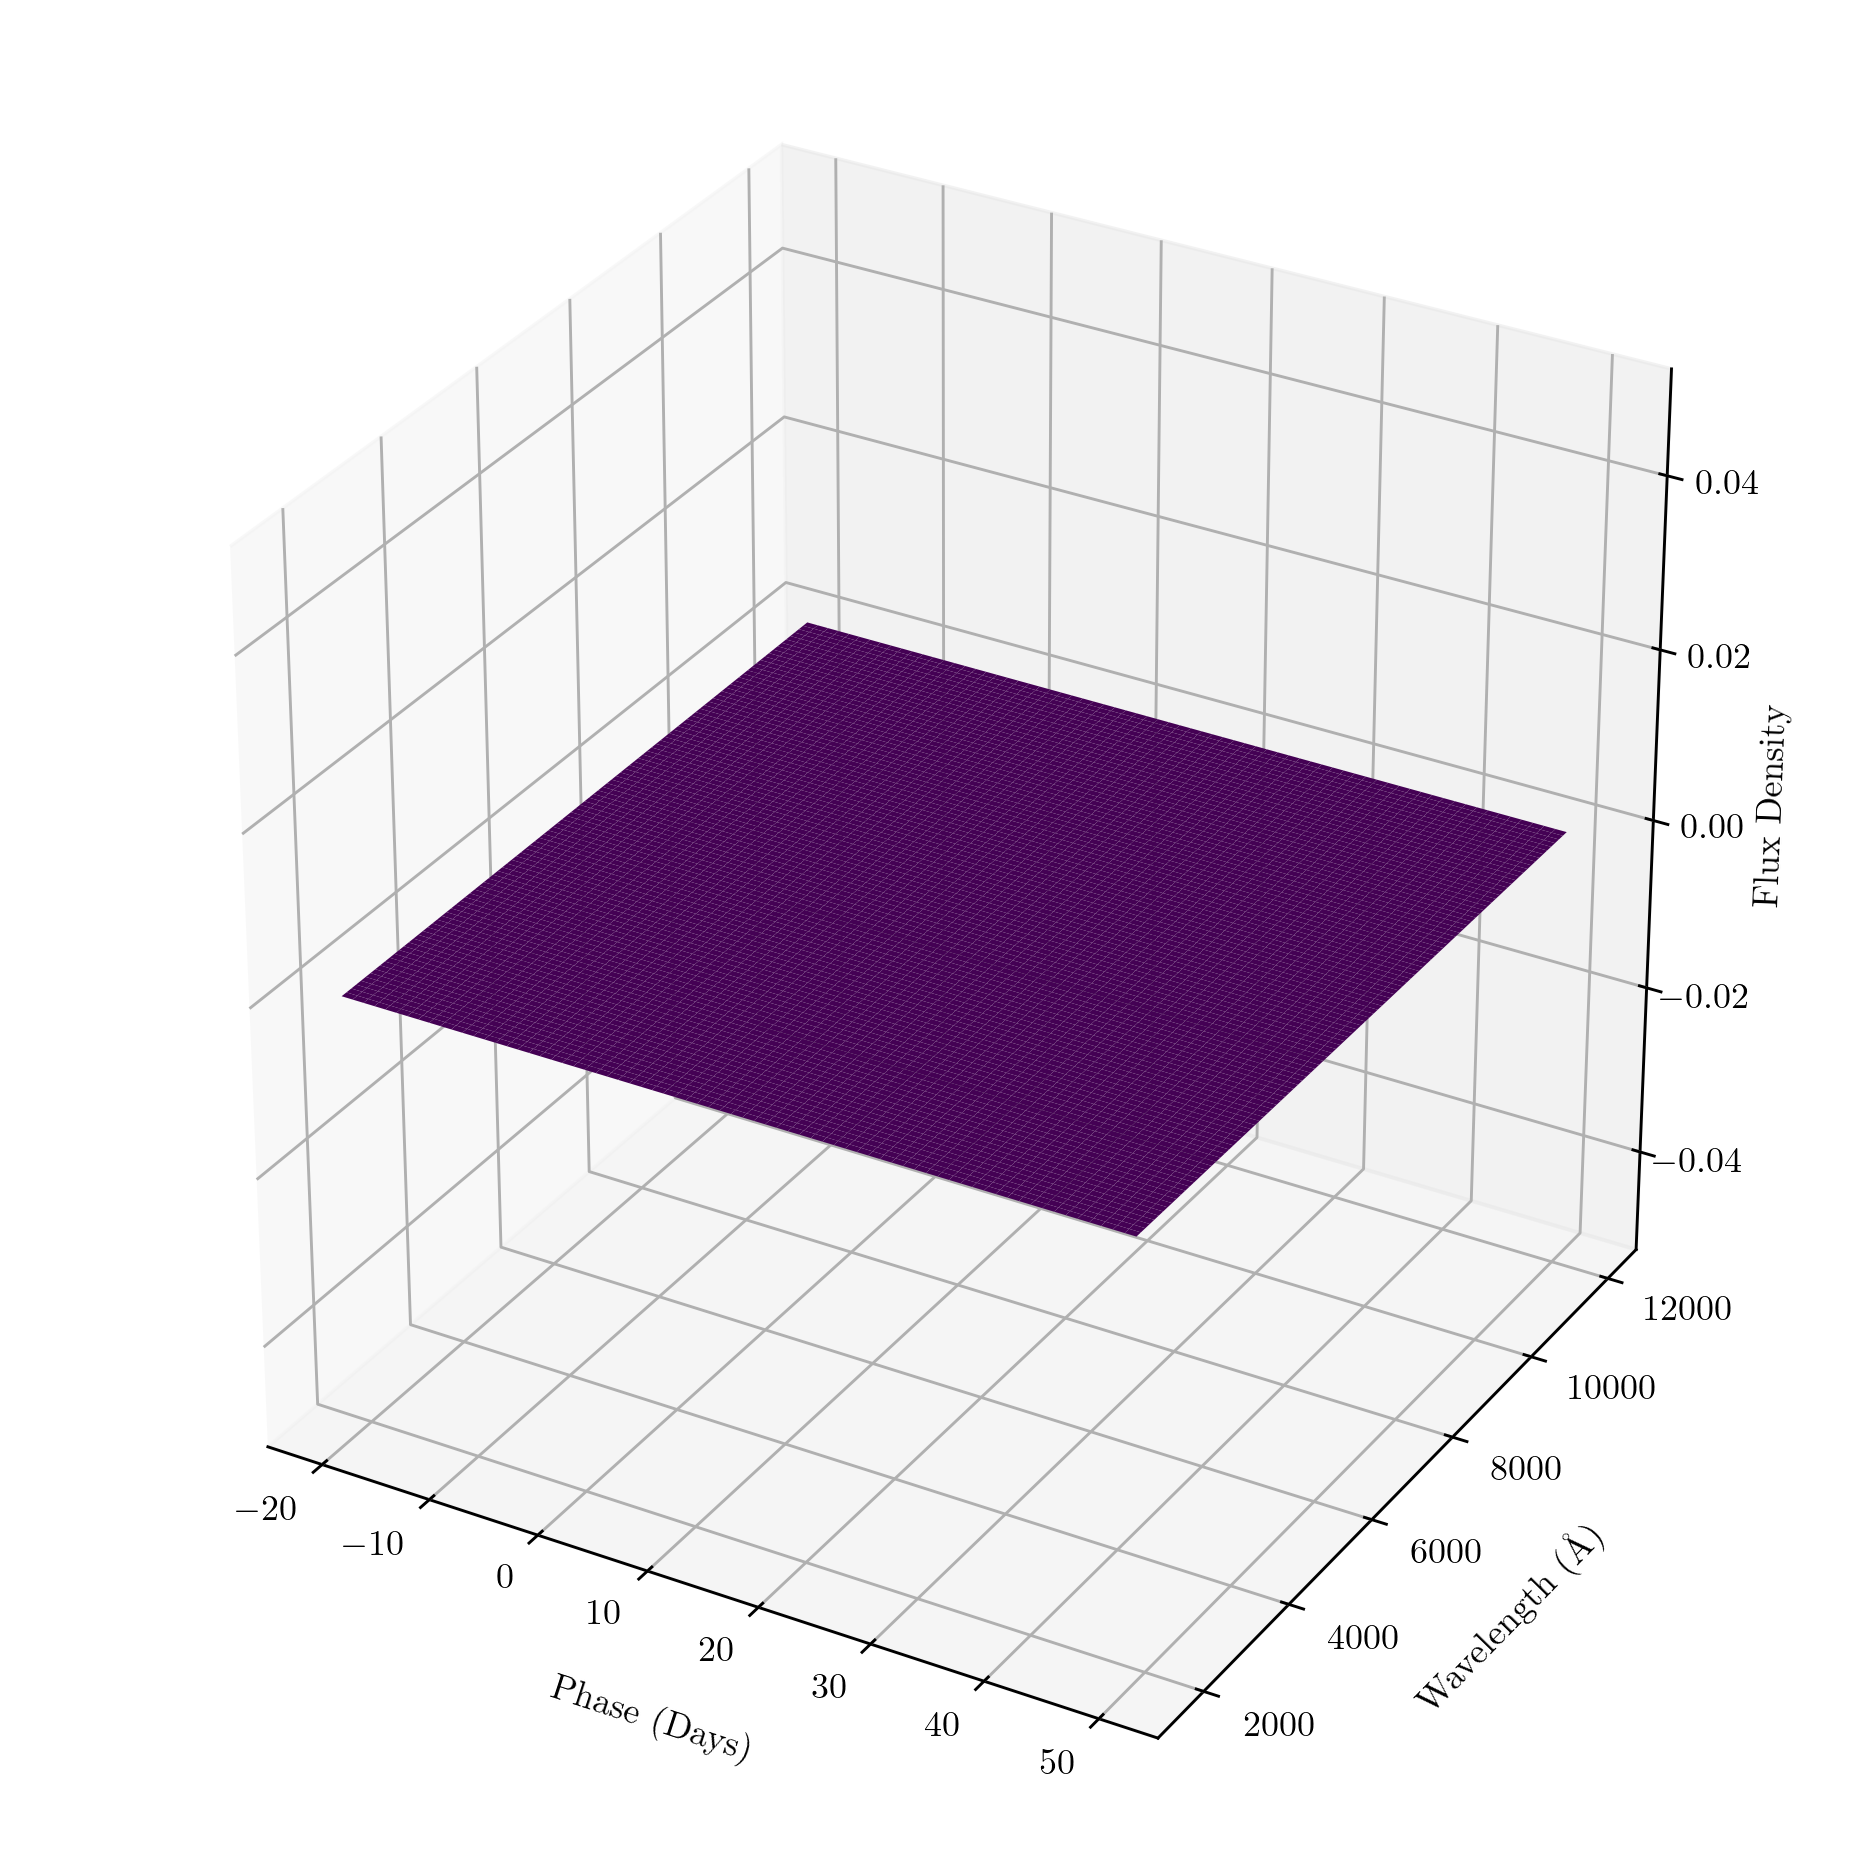

In [8]:
fig = lcn.surface_plot()

Let's make the time-slice training sets:

In [9]:
%time training_sets = lcn.training_sets(survey.obs)

CPU times: user 17 s, sys: 162 ms, total: 17.1 s
Wall time: 17.2 s


Before we start training, let's evaluate the weighted mean square error.

A perfect score is:

In [10]:
%time lc.mse(training_sets, bandpasses, Ncpus=8)

CPU times: user 5.65 s, sys: 395 ms, total: 6.04 s
Wall time: 8.24 s


6.763245635258569

Our null light curve currently has a score of

In [11]:
%time lcn.mse(training_sets, bandpasses, Ncpus=8)

CPU times: user 4.81 s, sys: 268 ms, total: 5.07 s
Wall time: 7.15 s


1994.3962438988144

Now train the light curve on the photometry in the simulated survey

In [12]:
%time lcn.train(training_sets, bandpasses, w=0.01, dmse_stop=0.01, Ncpus=8)

CPU times: user 5.25 s, sys: 288 ms, total: 5.54 s
Wall time: 22.6 s


After training, the wMSE is

In [13]:
%time lcn.mse(training_sets, bandpasses, Ncpus=3)

CPU times: user 3.1 s, sys: 200 ms, total: 3.3 s
Wall time: 9.44 s


6.025419921349761

Now plot the results!

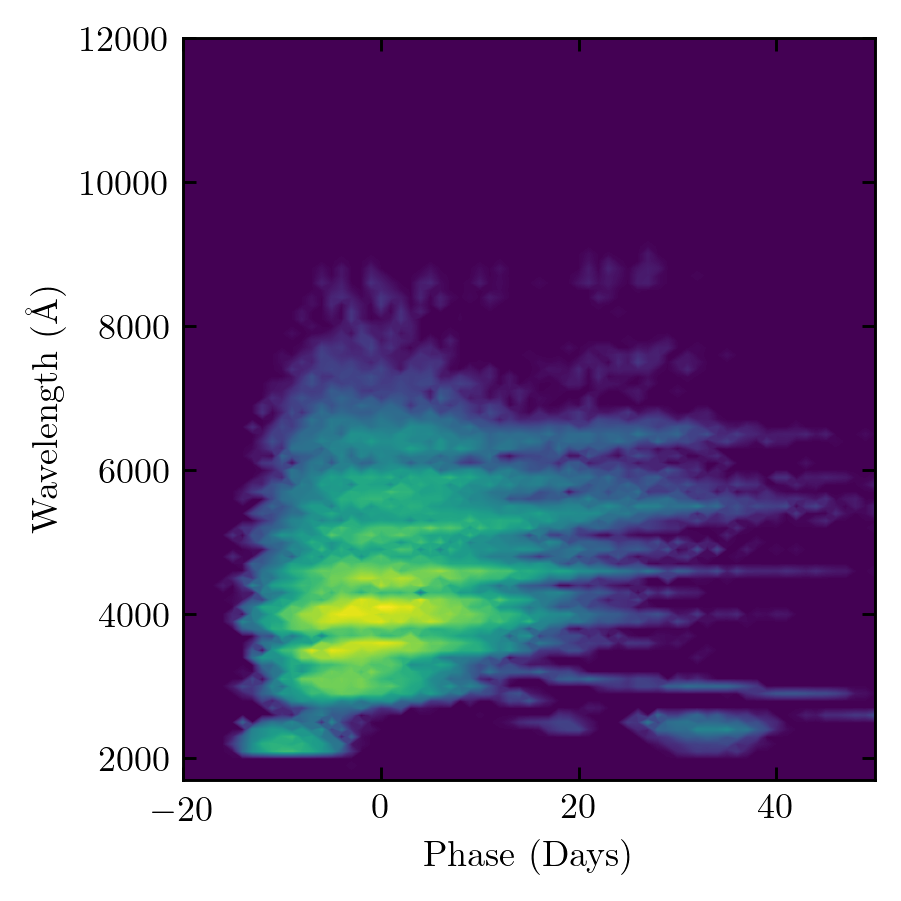

In [14]:
lcn.surface_plot()
lcn.contour_plot()
plt.show()

In [15]:
trange = [-5,0,5,10,15,20]
lcn.stacked_plot(trange, offset_scale=6)
plt.show()

Now I will make comparison plots. I plot the surfaces and contours side by side, and make a plot of the residuals.

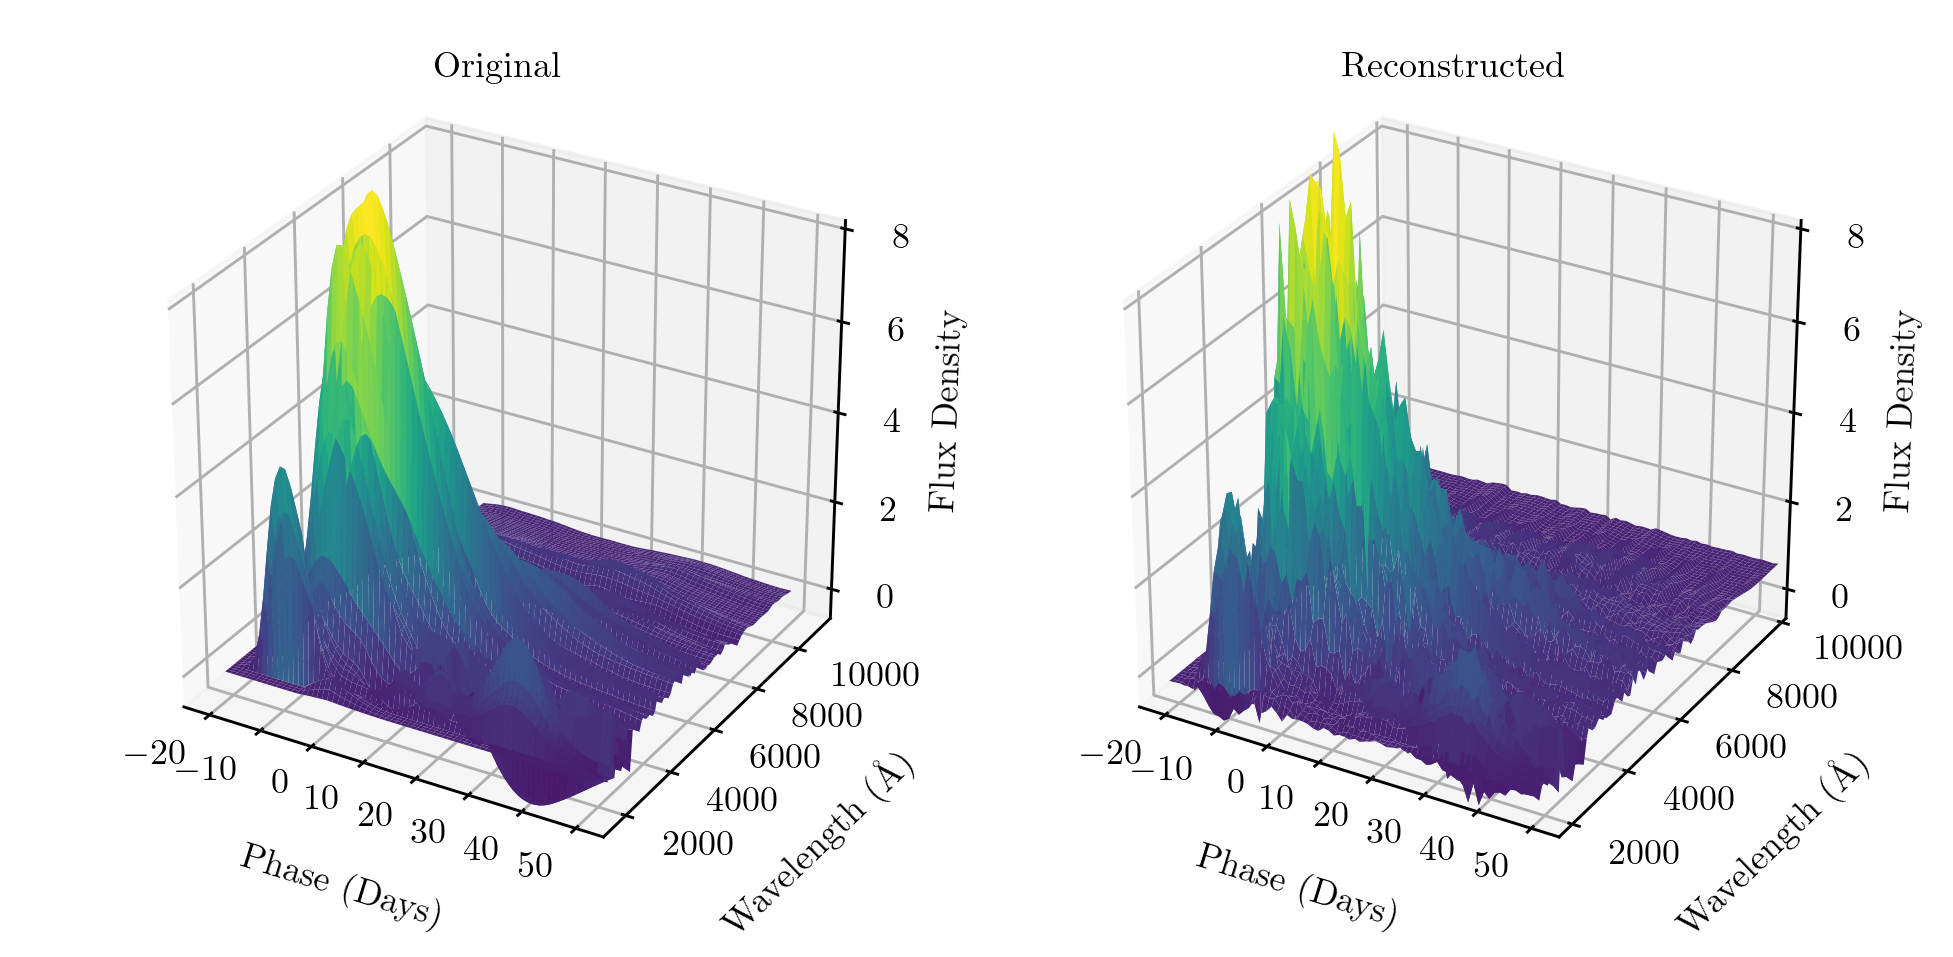

In [16]:
fig = plt.figure(figsize=(twocol,onecol))

ymax = 11000
idx = np.abs(lc.wavelen - ymax).argmin()
x, y = np.meshgrid(lc.time, lc.wavelen[:idx])

ax = fig.add_subplot(1,2,1, projection='3d')
ax.dist = 11

ax.plot_surface(x, y, lc.flux(lc.time,lc.wavelen[:idx]), cmap='viridis', rcount=200, ccount=200)
ax.set_zlim(-0.5, 8)
plt.setp( ax.xaxis.get_majorticklabels(), va="bottom", ha='right' )
plt.setp( ax.yaxis.get_majorticklabels(), va="bottom", ha='left' )
ax.set_xlabel("Phase (Days)", ha='left')
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)", labelpad=10)
ax.set_zlabel("Flux Density", labelpad=2)
ax.set_title("Original")

ax = fig.add_subplot(1,2,2, projection='3d')
ax.dist = 11
ax.plot_surface(x, y, lcn.flux(lcn.time,lcn.wavelen[:idx]), cmap='viridis', rcount=200, ccount=200)
ax.set_ylim(1700,10000)
ax.set_zlim(-0.5, 8)
plt.setp( ax.xaxis.get_majorticklabels(), va="bottom", ha='right' )
plt.setp( ax.yaxis.get_majorticklabels(), va="bottom", ha='left' )
ax.set_xlabel("Phase (Days)")
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)", labelpad=10)
ax.set_zlabel("Flux Density", labelpad=2)
ax.set_title("Reconstructed")

plt.subplots_adjust(wspace=0.01,top=1.07,bottom=0.03,left=-0.04,right=0.99)
fig.savefig('plots/surface_comparison.png')

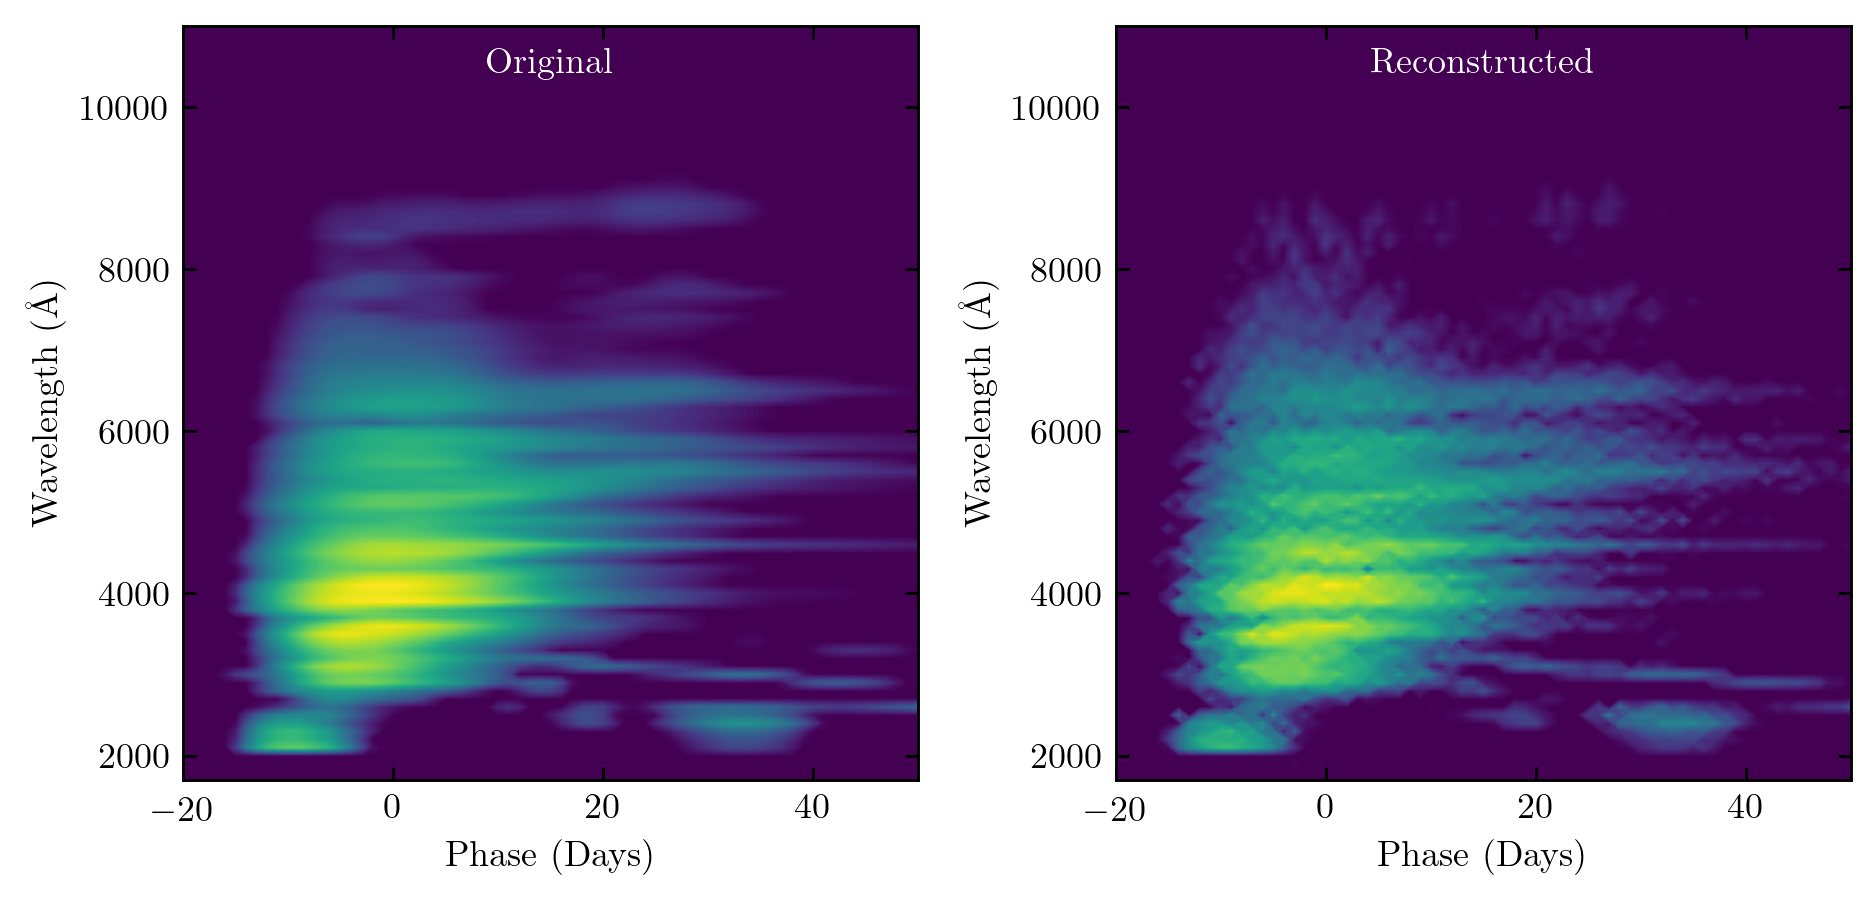

In [17]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(twocol,onecol),constrained_layout=True)

x,y = np.meshgrid(lc.time, lc.wavelen)

zcut = np.max(lc.flambda)/20
z = np.log10( np.clip(lc.flambda, zcut, None) )
ax1.contourf(x, y, z, levels=200)
ax1.set_xlabel("Phase (Days)")
ax1.set_ylabel("Wavelength ($\mathrm{\AA}$)")
ax1.set_ylim(1700, 11000)
ax1.text(0.5, 0.95, 'Original', transform=ax1.transAxes, ha='center', va='center', c='w')

zcut = np.max(lcn.flambda)/20
z = np.log10( np.clip(lcn.flambda, zcut, None) )
ax2.contourf(x, y, z, levels=200)
ax2.set_xlabel("Phase (Days)")
ax2.set_ylabel("Wavelength ($\mathrm{\AA}$)")
ax2.set_ylim(1700,11000)
ax2.text(0.5, 0.95, 'Reconstructed', transform=ax2.transAxes, ha='center', va='center', c='w')

fig.savefig('plots/contour_comparison.png')

In [18]:
fig,ax = plt.subplots()
P = 0
sed = lc.sed_slice(P)
ax.plot(sed.wavelen,sed.flambda,label="Original")
sed = lcn.sed_slice(P)
ax.plot(sed.wavelen,sed.flambda,label="Reconstructed")
ax.legend()
ax.set_xlabel("Wavelength ($\mathrm{\AA}$)")
ax.set_ylabel("Flux Density")

fig.savefig(f'plots/phase{P}_comparison.png')

In [19]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(0.9*twocol,onecol),constrained_layout=True)

trange = [-5,0,5,10,15,20]
offset_scale = 6

for i,t in enumerate(trange):
    sed = lc.sed_slice(t)
    idx = np.abs(sed.wavelen - 10000).argmin()
    ax1.plot(sed.wavelen[:idx], sed.flambda[:idx] + len(trange) - i*offset_scale, c='k')
    ax1.text(sed.wavelen[idx] + 100, sed.flambda[idx] + len(trange) - i*offset_scale, t, ha='left', va='center')

ax1.set_xlabel("Wavelength ($\mathrm{\AA}$)")
ax1.set_ylabel("Flux Density + Offset")
ax1.set_xlim(1200,10800)
ax1.set_ylim(-27, 18)
ax1.set_yticks([])

for i,t in enumerate(trange):
    sed = lcn.sed_slice(t)
    idx = np.abs(sed.wavelen - 10000).argmin()
    ax2.plot(sed.wavelen[:idx], sed.flambda[:idx] + len(trange) - i*offset_scale, c='k')
    ax2.text(sed.wavelen[idx] + 100, sed.flambda[idx] + len(trange) - i*offset_scale, t, ha='left', va='center')

ax2.set_xlabel("Wavelength ($\mathrm{\AA}$)")
ax2.set_ylabel("Flux Density + Offset")
ax2.set_xlim(1200,10800)
ax2.set_ylim(-27, 18)
ax2.set_yticks([])

fig.savefig('plots/stacked_comparison.png')

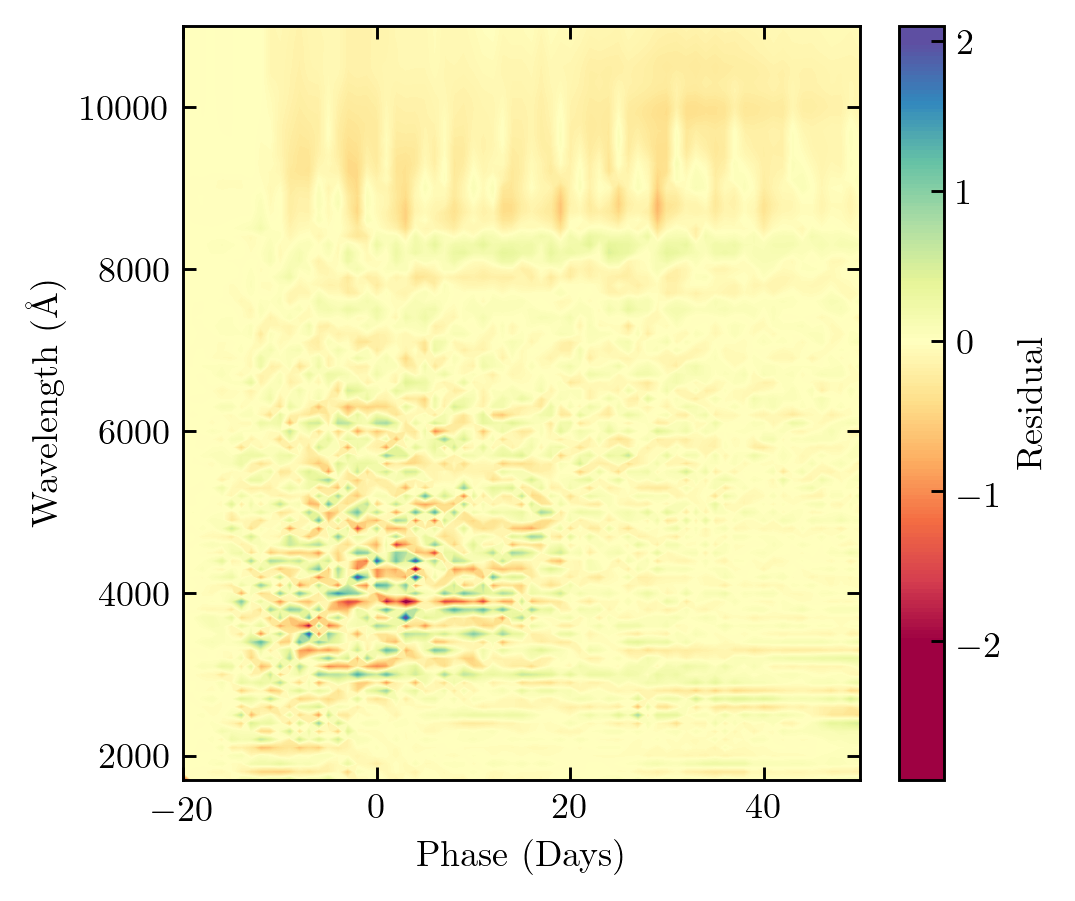

In [20]:
fig,ax = plt.subplots(figsize=(1.2*onecol,onecol), constrained_layout=True)

z = (lcn.flambda - lc.flambda)
zmax = 2
z[0,0], z[-1,-1] = -zmax, zmax
cont = ax.contourf(lc.time, lc.wavelen, z, cmap='Spectral', vmin=-zmax, vmax=zmax, levels=200)
fig.colorbar(cont, ticks=[-2,-1,0,1,2], label='Residual')
ax.set_xlabel("Phase (Days)")
ax.set_ylabel("Wavelength ($\mathrm{\AA}$)")
ax.set_ylim(1700,11000)

fig.savefig('plots/residuals.png')
plt.show()